In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from torch.utils.data import Dataset
from sklearn.utils import shuffle


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings = shuffle(ratings)

In [3]:
train_length = int(0.8 * len(ratings))
train_set    = ratings[:train_length]
val_set      = ratings[train_length:]

In [4]:
user_unique_ids  = list(ratings['userId'].unique())
movie_unique_ids = list(ratings['movieId'].unique())
movie_ids        = list(ratings['movieId'])

In [5]:
class MyDataset(Dataset):
    def __init__(self, ratings, movie_ids, movie_unique_ids):
        
        self.user_ids = list(ratings['userId']) 
        self.normal_movie_ids = [movie_unique_ids.index(x) for x in movie_ids]
        
        rate = ratings['rating']
        self.normalized_ratings = list((rate-min(rate))/(max(rate)-min(rate)))            
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.normal_movie_ids[idx], self.normalized_ratings[idx]
    
    def __len__(self):
        return len(self.user_ids)

In [6]:
batch_size = 32
train_dataset = MyDataset(train_set, movie_ids, movie_unique_ids)
val_dataset = MyDataset(val_set, movie_ids, movie_unique_ids)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=1,
                                         shuffle=False)

In [7]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, num_factors):
        super(MatrixFactorization, self).__init__()
        
        self.factor_user = nn.Embedding(num_users+1, num_factors, sparse=False)
        self.factor_item = nn.Embedding(num_items+1, num_factors, sparse=False)
        
    def forward(self, user, item):

        user_factor = self.factor_user(user)
        item_factor = self.factor_item(item)

        return (user_factor * item_factor).sum(dim=1)      

In [9]:
model = MatrixFactorization(len(user_unique_ids), len(movie_unique_ids), 32).to(device)
optimizer = optim.Adam(lr=0.0002, params=model.parameters())
criterion = nn.MSELoss()

In [10]:
def plot(epoch, train_losses, val_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Train | epoch: %s | loss: %s' % (epoch, train_losses[-1]))
    plt.plot(train_losses)
    plt.subplot(132)
    plt.title('Val | loss: %s' % (val_losses[-1]))
    plt.plot(val_losses)
    plt.show()

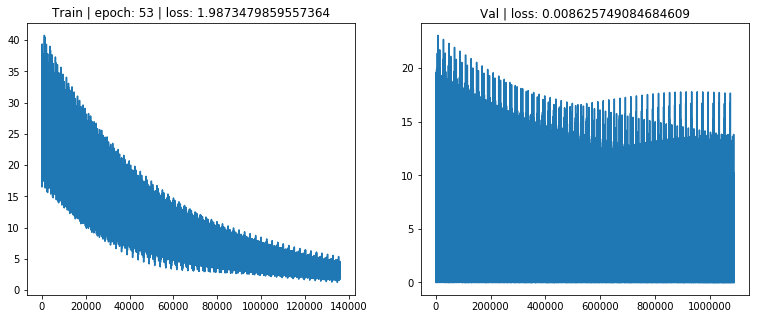

KeyboardInterrupt: 

In [12]:
def train():
    losses = []
    val_losses = []
    for epoch in range(100):
        
        model.train()
        for row in train_loader:
            
            optimizer.zero_grad()
            
            user = torch.tensor(row[0]).to(device)
            item = torch.tensor(row[1]).to(device)
            
            out = model(user, item)
            target = torch.tensor(row[2]).to(device)

            loss = criterion(target, out.double())
            loss.backward()
            optimizer.step()
                        
            losses.append(math.sqrt(loss.item()))
        
        
        model.eval()
        with torch.no_grad():
            for row in val_loader:
              
                user = torch.tensor(row[0]).to(device)
                item = torch.tensor(row[1]).to(device)
                
                out = model(user, item)
                
                target = torch.tensor(row[2]).to(device)
                val_loss = criterion(target, out.double())

                val_losses.append(math.sqrt(val_loss.item()))
        
        plot(epoch, losses, val_losses)
        
train()